<a href="https://colab.research.google.com/github/gavin-bauer/earth-vital-signs/blob/master/notebooks/temperatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLOBAL SURFACE TEMPERATURE ANALYSIS

## **About**
Below is code part of a personal project called [Earth's Vital Signs](https://github.com/gavin-bauer/earth-vital-signs/blob/master/README.md) intended to develop my proficiency in Data Science & Analytics tools and work on one of the most defining issues of our time. 

## **What I've learned**
Aside from becoming more familiar with the main Data Analysis libraries (ie: Numpy, Pandas and Matplotlib), I discovered a file format which called ***Hierarchical Data Format (HDF)*** which is designed to store and organize large amounts of data. Because I've never worked with HDF files before, it was really interesting to search and try new libraries to manipulate/visualize such data.

Finally, working on data provided by NASA and see if could reach the same conclusions was really cool !

## **Findings**
![Global Surface Temperatures](https://github.com/gavin-bauer/earth-vital-signs/blob/master/assets/img/gistemp.gif?raw=1)

**The world is getting warmer.** Evidence leans toward human activity being the cause as thermometer readings have risen steadily since the beginning of the Industrial Revolution.

![Global Surface Temperatures](https://github.com/gavin-bauer/earth-vital-signs/blob/master/assets/img/tempanomaly.png?raw=1)

**The average global temperature has increased by about 0.8° Celsius since 1880.** Two-thirds of the warming has occurred since 1975, at a rate of roughly 0.15-0.20°C per decade.

## **Dataset**
* [NASA](https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz)

### **Code**

In [0]:
# install Basemap in Google Colab
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
!pip install netCDF4
!pip install cmocean

In [0]:
# import libs
import os
import urllib.request
from netCDF4 import Dataset
from netCDF4 import date2index
from netCDF4 import num2date
from datetime import datetime
import numpy as np
import pandas as pd
import scipy as sp
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cmocean
import imageio as io
from IPython.display import Image

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'

In [0]:
def download_gistemp_dataset(link: str, destination: str):
  try:
    urllib.request.urlretrieve(link, destination)
    print('Download successful.')
  except Exception as e:
    print('Data was not retrieved.')
    print(e)

  !gunzip gistemp1200_GHCNv4_ERSSTv5.nc.gz

  data = Dataset(destination[9:-3])
  return data

def plot_gistemp(data, index):
  lons = data.variables['lon'][:]
  lats = data.variables['lat'][:]
  loti = data.variables['tempanomaly']
  temp_anomaly = data.variables['tempanomaly'][index]
  date = num2date(data.variables['time'][index],
                  units='days since 1800-01-01 00:00:00').strftime('%m/%Y')
  
  m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='l')
  lon, lat = sp.meshgrid(lons, lats)
  xi, yi = m(lon, lat)

  fig, ax = plt.subplots()
  cs = m.pcolor(xi,yi,loti[index,:,:],vmin=-16,vmax=16,cmap=cmocean.cm.balance)
  m.drawparallels(sp.arange(-80., 81., 20.), labels=[1,0,0,0], fontsize=10)
  m.drawmeridians(sp.arange(-180., 181., 40.), labels=[0,0,0,1], fontsize=10)
  m.drawcoastlines()
  m.drawcountries()
  cbar = m.colorbar(cs, location='bottom', pad="10%")
  cbar.set_label('degC')
  plt.title(f'Global Surface Temperatures {date}')
  return date, ax

def download_loti_dataset(link: str):
  columns_name = ['Year', 'No_Smoothing', 'Lowess(5)']
  dataset = pd.read_csv(link, sep='     ', skiprows=5, names=columns_name)
  return dataset

def plot_loti(link):
  dataset = download_loti_dataset(link)
  year = dataset['Year']
  no_smoothing = dataset['No_Smoothing']
  lowess = dataset['Lowess(5)']
  fig, ax = plt.subplots()
  ax.plot(year, no_smoothing, 'k:', label='no smoothing')
  ax.plot(year, lowess, label='lowess (5)')
  ax.set(xlabel='year', ylabel='surface temperature (Celsius)',
        title='Surface Temp Change Relative To 1951-1980 Avg Temp')
  ax.set_yticks(np.arange(-0.5, 1.0, 0.5))
  ax.grid(color='#7f7f7f', linewidth=0.2)
  legend = ax.legend(loc='upper left')
  return ax

def make_gif():
  file_names = sorted((fn for fn in os.listdir('/content') if fn.endswith('jpeg')))
  with io.get_writer('gistemp.gif', mode='I', duration=0.5) as writer:
    for filename in file_names:
      image = io.imread(filename)
      writer.append_data(image)
  writer.close()

In [0]:
link = 'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
destination = '/content/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
data = download_gistemp_dataset(link, destination)

In [0]:
deltat = data.variables['time']
for index in range(0, len(deltat), 240):
  date, ax = plot_gistemp(data, index)
  year = date[-4:]
  PATH = os.path.join('/content', f'gistemp_{year}.jpeg')
  chart = ax.get_figure()
  chart.savefig(PATH, dpi=150)

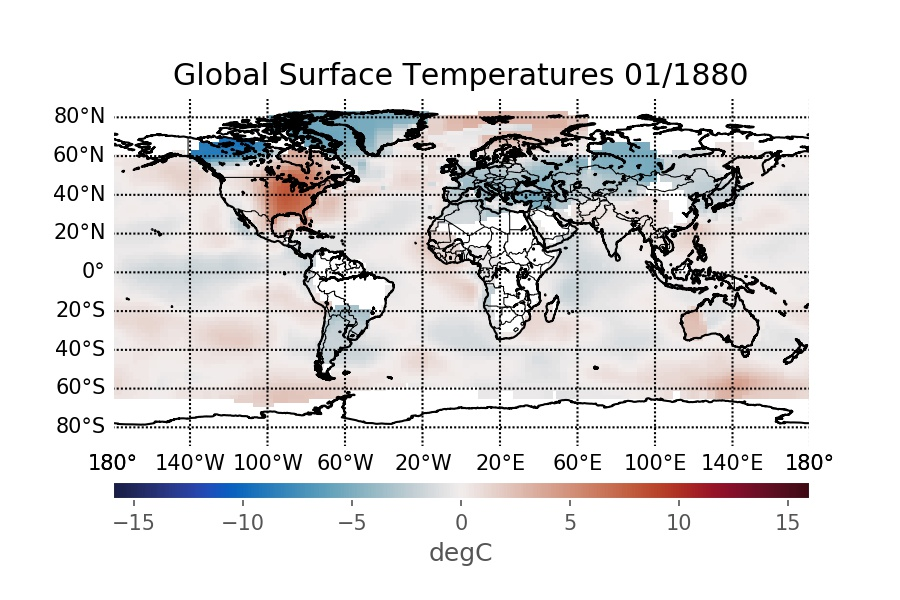

In [0]:
Image('gistemp_1880.jpeg', width=400, height=400)

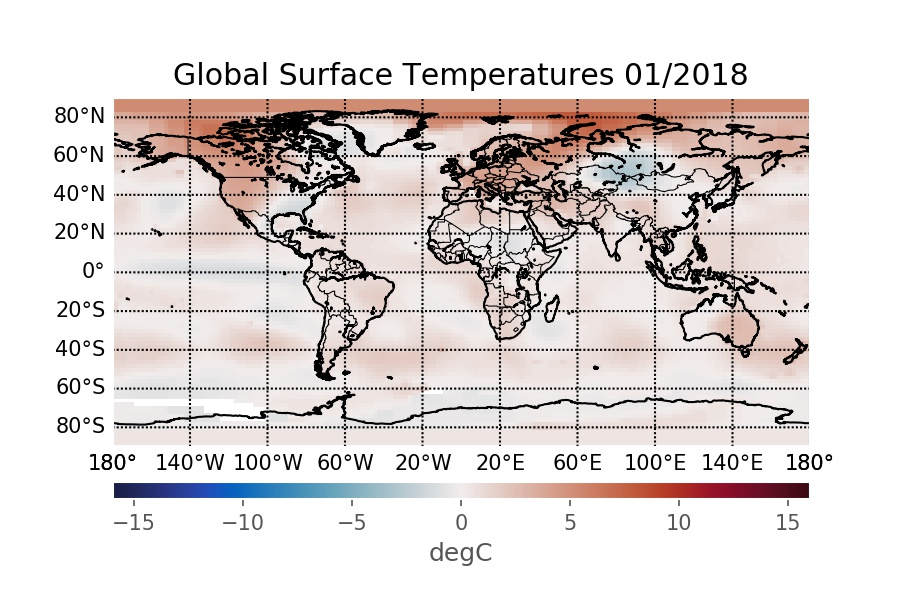

In [0]:
Image('gistemp_2018.jpeg', width=400, height=400)

In [0]:
make_gif()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


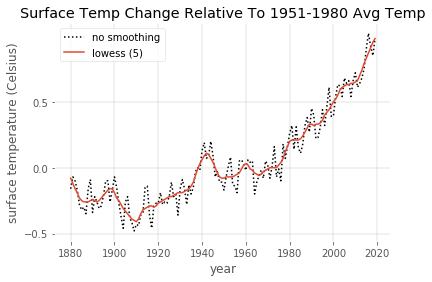

In [0]:
link = 'https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt'
PATH = os.path.join('/content', 'loti')
ax = plot_loti(link)
chart = ax.get_figure()
chart.savefig(PATH, dpi=150)